# Polarity 数据预处理

# SCSN

In [2]:
import pandas as pd
import numpy as np
import h5py
f=h5py.File('/mnt/f/AI_Seismic_Data/scsn/scsn_p_2000_2017_6sec_0.5r_fm_train.hdf5','r')
f1=h5py.File('/mnt/f/AI_Seismic_Data/scsn/scsn_p_2000_2017_6sec_0.5r_fm_test.hdf5','r')

print(f"train-fm keys:{f.keys()}")
print(f"test-fm keys:{f1.keys()}")

train-fm keys:<KeysViewHDF5 ['X', 'Y', 'dist', 'evids', 'mag', 'sncls', 'snr']>
test-fm keys:<KeysViewHDF5 ['X', 'Y', 'dist', 'evids', 'mag', 'sncls', 'snr']>


In [3]:
# 安装最快的JSON库
!pip install orjson

ERROR: Operation cancelled by user
^C


In [ ]:
# 训练，验证数据是Ross已经划分好了
train_X=f['X'][:]
train_Y=f['Y'][:]
test_X=f1['X'][:]
test_Y=f1['Y'][:]
print(f"train_X shape:{train_X.shape}, train_Y shape:{train_Y.shape}")
print(f"test_X shape:{test_X.shape}, test_Y shape:{test_Y.shape}")

train_X shape:(2494194, 600), train_Y shape:(2494194,)
test_X shape:(2353054, 600), test_Y shape:(2353054,)


In [ ]:
#查看其类别
print(f"train_Y unique classes:{np.unique(train_Y, return_counts=True)}")
print(f"test_Y unique classes:{np.unique(test_Y, return_counts=True)}")
# scsn数据的的P波全是3.0，但是训练时需要在300点左右进行裁剪，这是论文方法做法
pick=h5py.File('/mnt/f/AI_Seismic_Data/scsn/scsn_p_2000_2017_6sec_0.5r_pick_train.hdf5','r')
print(f"pick train keys:{pick.keys()}")
print(f"counts of pick_Y:{np.unique(pick['Y'][:], return_counts=True)}")

train_Y unique classes:(array([0, 1, 2], dtype=uint8), array([831398, 831398, 831398]))
test_Y unique classes:(array([0, 1, 2], dtype=uint8), array([ 586018,  277133, 1489903]))
pick train keys:<KeysViewHDF5 ['X', 'Y', 'dist', 'evids', 'fm', 'mag', 'sncls', 'snr']>
counts of pick_Y:(array([3.], dtype=float32), array([3635436]))


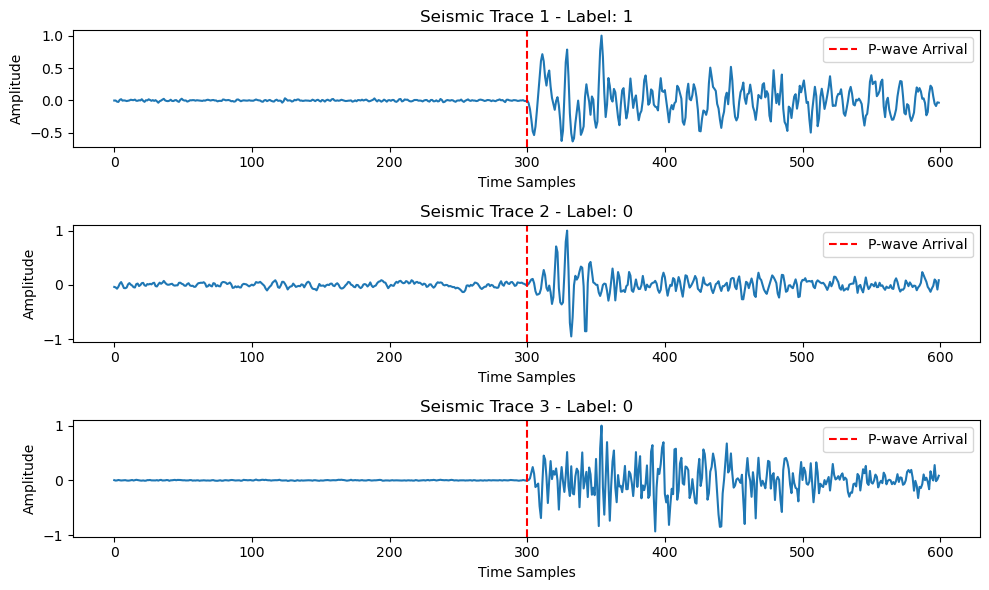

In [ ]:
# 绘制波形,绘制3行1列(label 0表示正向，1表示负向，2表示不确定)
import matplotlib.pyplot as plt
fig, axs = plt.subplots(3, 1, figsize=(10, 6))
time = np.arange(train_X.shape[1])  
for i in range(3):
    axs[i].plot(time, train_X[i])
    axs[i].axvline(x=300, color='r', linestyle='--', label='P-wave Arrival')
    axs[i].legend()
    axs[i].set_title(f'Seismic Trace {i+1} - Label: {train_Y[i]}')
    axs[i].set_xlabel('Time Samples')
    axs[i].set_ylabel('Amplitude')
plt.tight_layout()
plt.show()

## SCSN-Ross model

Ross使用的数据集是SCSN数据集。虽然`scsn_p_2000_2017_6sec_0.5r_fm_train.hdf5`与`scsn_p_2000_2017_6sec_0.5r_fm_test.hdf5`可以直接用于训练和验证，但是复现Ross论文的时候，需要在300样本点处左右各截取200样本点组成400才是论文的输入。

## SCSN-Eqpolarity model

Eqpolarity使用的数据集也是SCSN数据集。与Ross不同的是，Eqpolarity使用的数据集是`scsn_p_2000_2017_6sec_0.5r_fm_train.hdf5`与`scsn_p_2000_2017_6sec_0.5r_fm_test.hdf5`直接作为输入，没有进行截取。

# Txed

## Txed-Eqpolarity model

In [ ]:
import pandas as pd
import numpy as np
import h5py

csv=pd.read_csv('/mnt/f/AI_Seismic_Data/txed/Txed.csv')
f=h5py.File('/mnt/f/AI_Seismic_Data/txed/Txed.hdf5','r')
print(f"Txed hdf5 keys:{f.keys()}")
csv['trace_polarity'].value_counts()
labels=np.load('data/Txed_Fune_Tune/Fune_Tune_Txed_Labels.npy')
print(f"Up and Down polarity counts: {np.unique(labels, return_counts=True)}")

/tmp/ipykernel_1773835/3332370443.py:5: DtypeWarning: Columns (7,10,12,21,22) have mixed types. Specify dtype option on import or set low_memory=False.
  csv=pd.read_csv('/mnt/c/Users/yuan/seispolarity/Txed.csv')


Txed hdf5 keys:<KeysViewHDF5 ['data', 'data_format']>
Up and Down polarity counts: (array([0, 1]), array([14543,  8437]))


仅使用 10% 的德克萨斯数据（9%训练，1%验证）对在加州数据上预训练的模型进行微调。

此处原文没说txed的数据平衡处理，???(论文没说，)，但是作者给了数据，只能先用

| unknown	 |   288897   |
| :---------------- | ---- |
| U	        |   14671   |
| D	        |   8663    |



# DiTing 

(只有diting1.0有P波初动数据，diting2.0只有249477个Pg波、41610个Pn初动极性标签)

In [ ]:
import pandas as pd
import numpy as np
import os
import glob
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

In [ ]:
csv=pd.read_csv('/mnt/f/AI_Seismic_Data/DiTing1/DiTing50hz/DiTing330km_part_0.csv')
csv

,Unnamed: 0,part,key,ev_id,evmag,mag_type,p_pick,p_clarity,p_motion,s_pick,...,N_P_amplitude_snr,N_P_power_snr,N_S_amplitude_snr,N_S_power_snr,E_P_amplitude_snr,E_P_power_snr,E_S_amplitude_snr,E_S_power_snr,P_residual,S_residual
0,0,0,1.0004,1,1.5,ML,1743,E,,2615,...,1.500,3.481,2.279,10.628,1.500,3.481,2.279,10.628,0.10,2.24
1,1,0,1.0003,1,1.5,ML,1215,E,,1399,...,1.307,0.067,4.273,16.639,1.307,0.067,4.273,16.639,-0.04,1.17
2,2,0,1.0001,1,1.5,ML,2196,E,,2939,...,0.948,-0.895,1.526,2.751,0.948,-0.895,1.526,2.751,-0.14,1.70
3,3,0,1.0002,1,1.5,ML,2572,,,3710,...,3.510,4.594,1.054,1.272,3.510,4.594,1.054,1.272,-0.62,1.97
4,4,0,2.0007,2,1.0,ML,662,,R,733,...,3.202,2.393,3.603,10.445,3.202,2.393,3.603,10.445,0.00,0.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,99995,0,36200.0066,36200,2.3,ML,1285,,R,1812,...,1.865,0.822,1.112,0.238,1.865,0.822,1.112,0.238,-0.29,0.22
99996,99996,0,36200.0122,36200,2.3,ML,1710,,,2045,...,1.001,0.000,1.001,-0.000,1.001,0.000,1.001,-0.000,-0.03,0.16
99997,99997,0,36200.0353,36200,2.3,ML,1929,,,2713,...,1.040,0.098,1.016,-0.266,1.040,0.098,1.016,-0.266,0.20,0.81
99998,99998,0,36200.0245,36200,2.3,ML,2664,E,,3720,...,1.023,0.698,1.526,5.543,1.023,0.698,1.526,5.543,-0.42,0.55


In [ ]:
print(csv['p_motion'].value_counts())
print(csv['p_clarity'].value_counts())

p_motion
     72447
U    13747
R    13170
C      330
D      306
Name: count, dtype: int64
p_clarity
     68838
E    17176
I    13919
(       67
Name: count, dtype: int64


In [ ]:
import h5py
f1=h5py.File('/mnt/f/AI_Seismic_Data/DiTing1/DiTing50hz/DiTing330km_part_0.hdf5','r')
f2=f1['earthquake']
keys=list(f2.keys())
print(f"Keys in DiTing hdf5 earthquake group: {keys[0:10]}")

Keys in DiTing hdf5 earthquake group: ['000001.0001', '000001.0002', '000001.0003', '000001.0004', '000002.0005', '000002.0006', '000002.0007', '000002.0008', '000002.0009', '000003.0010']


In [ ]:
data=f2['000001.0001']
data.shape

(9000, 3)

每个hdf5数据的内部数据标签。但是csv里面的key是2.0007这种数值。所以按理说应该处理为'000002.0007'。也就是说小数点前有6位，小数点后是4位的字符串。

## SCSN-DiTing datasets

SCSN只包含U，D，K标签（polarity）。DiTing是含有U，D，K标签（polarity），同时含有 Impulsive (I)、Emergent (E) 和 Uncertain (−) 标签（clarity）。

对于组合数据集，论文是将SCSN都标记为Uncertain (−) 标签（clarity）。目前在于测试和使用时强制输出为U，D（可以将原始为K的标签识别出具体的polarity）

### CSV批量处理

1. 将csv文件中的key进行格式化处理，变为'000002.0007'这种形式。
2. 将每个csv的p_motion列的空值填充为'X'。将P_clarity列的空值和"("填充为"K"
3. 根据U D的数量随机选取相同数量的K样本，组成新的csv文件。


In [ ]:
# 批量处理DiTing50hz目录下的所有CSV文件
print("开始批量处理DiTing50hz目录下的所有CSV文件...")

import pandas as pd
import numpy as np
import os
import glob
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# 定义处理单个CSV文件的函数
def process_diting_csv(file_path):
    """
    处理单个DiTing CSV文件
    返回处理后的DataFrame
    """
    print(f"处理文件: {os.path.basename(file_path)}")
    
    # 1. 读取CSV文件
    df = pd.read_csv(file_path)
    print(f"  原始数据形状: {df.shape}")
    
    # 2. 创建副本进行处理
    df_processed = df.copy()
    
    # 3. 处理p_motion：将空字符（空格、空字符串）替换为'X'
    df_processed['p_motion_processed'] = df_processed['p_motion'].copy()
    df_processed['p_motion_processed'] = df_processed['p_motion_processed'].str.strip()
    df_processed.loc[df_processed['p_motion_processed'] == '', 'p_motion_processed'] = 'X'
    
    # 4. 处理p_clarity：将空字符和包含"("的值替换为'K'
    df_processed['p_clarity_processed'] = df_processed['p_clarity'].copy()
    df_processed['p_clarity_processed'] = df_processed['p_clarity_processed'].str.strip()
    df_processed.loc[df_processed['p_clarity_processed'] == '', 'p_clarity_processed'] = 'K'
    
    # 处理包含"("的值
    contains_parenthesis = df_processed['p_clarity_processed'].str.contains('\\(', na=False)
    df_processed.loc[contains_parenthesis, 'p_clarity_processed'] = 'K'
    
    # 5. 提取U、D和随机X行
    # 提取U行（p_motion_processed为U）
    u_rows = df_processed[df_processed['p_motion_processed'] == 'U']
    
    # 提取D行（p_motion_processed为D）
    d_rows = df_processed[df_processed['p_motion_processed'] == 'D']
    
    # 提取X行（p_motion_processed为X）
    x_rows = df_processed[df_processed['p_motion_processed'] == 'X']
    
    # 计算需要提取的X行数量（与U+D的数量相同）
    ud_count = len(u_rows) + len(d_rows)
    
    # 从X行中随机抽取与U+D数量相同的行
    if len(x_rows) >= ud_count:
        x_random = x_rows.sample(n=ud_count, random_state=42)
    else:
        x_random = x_rows
    
    # 合并U、D和随机X行
    selected_rows = pd.concat([u_rows, d_rows, x_random], ignore_index=True)
    
    # 6. 处理key列格式
    if 'key' in selected_rows.columns:
        selected_rows['key'] = selected_rows['key'].astype(str)
        
        def format_key(key_str):
            try:
                if '.' in key_str:
                    int_part, dec_part = key_str.split('.')
                else:
                    int_part = key_str
                    dec_part = '0'
                
                int_part = int_part.zfill(6)
                dec_part = dec_part.ljust(4, '0')[:4]
                
                return f"{int_part}.{dec_part}"
            except:
                return key_str
        
        selected_rows['key_formatted'] = selected_rows['key'].apply(format_key)
    
    print(f"  处理后选中行数: {len(selected_rows)}")
    print(f"  U行数: {len(u_rows)}, D行数: {len(d_rows)}, X行数: {len(x_random)}")
    print(f"  U+D = X: {len(u_rows) + len(d_rows) == len(x_random)}")
    
    return selected_rows

# 获取所有CSV文件
csv_dir = '/mnt/f/AI_Seismic_Data/DiTing1/DiTing50hz'
csv_files = glob.glob(os.path.join(csv_dir, '*.csv'))
print(f"\n找到 {len(csv_files)} 个CSV文件")

# 处理所有文件
all_processed_data = []
for i, csv_file in enumerate(csv_files, 1):
    print(f"\n[{i}/{len(csv_files)}] ", end="")
    try:
        processed_df = process_diting_csv(csv_file)
        all_processed_data.append(processed_df)
    except Exception as e:
        print(f"处理文件 {os.path.basename(csv_file)} 时出错: {e}")

print(f"\n成功处理了 {len(all_processed_data)} 个文件")

开始批量处理DiTing50hz目录下的所有CSV文件...

找到 28 个CSV文件

[1/28] 处理文件: DiTing330km_part_0.csv
  原始数据形状: (100000, 29)
  处理后选中行数: 28106
  U行数: 13747, D行数: 306, X行数: 14053
  U+D = X: True

[2/28] 处理文件: DiTing330km_part_1.csv
  原始数据形状: (100000, 29)
  处理后选中行数: 27664
  U行数: 13406, D行数: 426, X行数: 13832
  U+D = X: True

[3/28] 处理文件: DiTing330km_part_10.csv
  原始数据形状: (100000, 29)
  处理后选中行数: 25008
  U行数: 12156, D行数: 348, X行数: 12504
  U+D = X: True

[4/28] 处理文件: DiTing330km_part_11.csv
  原始数据形状: (100000, 29)
  处理后选中行数: 24664
  U行数: 11854, D行数: 478, X行数: 12332
  U+D = X: True

[5/28] 处理文件: DiTing330km_part_12.csv
  原始数据形状: (100000, 29)
  处理后选中行数: 23580
  U行数: 11425, D行数: 365, X行数: 11790
  U+D = X: True

[6/28] 处理文件: DiTing330km_part_13.csv
  原始数据形状: (100000, 29)
  处理后选中行数: 24968
  U行数: 9802, D行数: 2682, X行数: 12484
  U+D = X: True

[7/28] 处理文件: DiTing330km_part_14.csv
  原始数据形状: (100000, 29)
  处理后选中行数: 24686
  U行数: 11887, D行数: 456, X行数: 12343
  U+D = X: True

[8/28] 处理文件: DiTing330km_part_15.csv
  原始数据形状: (10000

In [ ]:
# 合并所有处理后的数据
print("\n合并所有处理后的数据...")

if all_processed_data:
    # 合并所有DataFrame
    merged_df = pd.concat(all_processed_data, ignore_index=True)
    
    print(f"合并后的总数据形状: {merged_df.shape}")
    print(f"总行数: {len(merged_df)}")
    print(f"总列数: {merged_df.shape[1]}")
    
    # 显示数据分布
    print("\n合并后数据分布:")
    print("p_motion_processed分布:")
    print(merged_df['p_motion_processed'].value_counts())
    print("\np_clarity_processed分布:")
    print(merged_df['p_clarity_processed'].value_counts())
    
    # 验证U+D等于X
    u_count = len(merged_df[merged_df['p_motion_processed'] == 'U'])
    d_count = len(merged_df[merged_df['p_motion_processed'] == 'D'])
    x_count = len(merged_df[merged_df['p_motion_processed'] == 'X'])
    
    print(f"\n验证U+D等于X:")
    print(f"U行数: {u_count}")
    print(f"D行数: {d_count}")
    print(f"X行数: {x_count}")
    print(f"U+D: {u_count + d_count}")
    print(f"U+D 是否等于 X: {u_count + d_count == x_count}")
    
    # 显示各文件的贡献
    print(f"\n各文件处理结果:")
    for i, df in enumerate(all_processed_data):
        print(f"  文件{i+1}: {len(df)} 行")
else:
    print("没有处理任何数据！")


合并所有处理后的数据...
合并后的总数据形状: (694944, 32)
总行数: 694944
总列数: 32

合并后数据分布:
p_motion_processed分布:
p_motion_processed
X    347472
U    334099
D     13373
Name: count, dtype: int64

p_clarity_processed分布:
p_clarity_processed
K    441384
I    188343
E     65217
Name: count, dtype: int64

验证U+D等于X:
U行数: 334099
D行数: 13373
X行数: 347472
U+D: 347472
U+D 是否等于 X: True

各文件处理结果:
  文件1: 28106 行
  文件2: 27664 行
  文件3: 25008 行
  文件4: 24664 行
  文件5: 23580 行
  文件6: 24968 行
  文件7: 24686 行
  文件8: 8518 行
  文件9: 12066 行
  文件10: 14240 行
  文件11: 27740 行
  文件12: 27136 行
  文件13: 35564 行
  文件14: 28512 行
  文件15: 28154 行
  文件16: 29486 行
  文件17: 26716 行
  文件18: 25356 行
  文件19: 26446 行
  文件20: 23464 行
  文件21: 10546 行
  文件22: 36388 行
  文件23: 28538 行
  文件24: 28290 行
  文件25: 24978 行
  文件26: 24428 行
  文件27: 25480 行
  文件28: 24222 行


In [ ]:
# 保存最终的合并CSV文件
print("\n保存最终的合并CSV文件...")

# 保存合并后的数据
output_file = 'DiTing_all_processed_merged.csv'
merged_df.to_csv(output_file, index=False)
print(f"已保存合并后的 {len(merged_df)} 行到文件: {output_file}")

# 显示保存的文件信息
file_size_mb = os.path.getsize(output_file) / (1024 * 1024)
print(f"文件大小: {file_size_mb:.2f} MB")
print(f"文件列数: {merged_df.shape[1]}")
print(f"文件列名: {list(merged_df.columns)}")

# 创建数据摘要
print("\n数据摘要:")
print(f"总文件数: {len(csv_files)}")
print(f"成功处理文件数: {len(all_processed_data)}")
print(f"总数据行数: {len(merged_df):,}")
print(f"U行数: {u_count:,}")
print(f"D行数: {d_count:,}")
print(f"X行数: {x_count:,}")
print(f"U+D = X: {u_count + d_count == x_count}")

# 保存数据摘要到文本文件
summary_file = 'DiTing_processing_summary.txt'
with open(summary_file, 'w') as f:
    f.write("DiTing数据处理摘要\n")
    f.write("=" * 50 + "\n")
    f.write(f"处理时间: {pd.Timestamp.now()}\n")
    f.write(f"总文件数: {len(csv_files)}\n")
    f.write(f"成功处理文件数: {len(all_processed_data)}\n")
    f.write(f"总数据行数: {len(merged_df):,}\n")
    f.write(f"输出文件: {output_file}\n")
    f.write(f"文件大小: {file_size_mb:.2f} MB\n")
    f.write("\n数据分布:\n")
    f.write("p_motion_processed分布:\n")
    f.write(str(merged_df['p_motion_processed'].value_counts()) + "\n")
    f.write("\np_clarity_processed分布:\n")
    f.write(str(merged_df['p_clarity_processed'].value_counts()) + "\n")
    f.write("\n验证结果:\n")
    f.write(f"U行数: {u_count:,}\n")
    f.write(f"D行数: {d_count:,}\n")
    f.write(f"X行数: {x_count:,}\n")
    f.write(f"U+D = X: {u_count + d_count == x_count}\n")
    f.write("\n各文件处理结果:\n")
    for i, df in enumerate(all_processed_data):
        f.write(f"  文件{i+1}: {len(df)} 行\n")

print(f"\n数据摘要已保存到: {summary_file}")
print("\n批量处理完成！")


保存最终的合并CSV文件...
已保存合并后的 694944 行到文件: DiTing_all_processed_merged.csv
文件大小: 112.62 MB
文件列数: 32
文件列名: ['Unnamed: 0', 'part', 'key', 'ev_id', 'evmag', 'mag_type', 'p_pick', 'p_clarity', 'p_motion', 's_pick', 'net', 'sta_id', 'dis', 'st_mag', 'baz', 'Z_P_amplitude_snr', 'Z_P_power_snr', 'Z_S_amplitude_snr', 'Z_S_power_snr', 'N_P_amplitude_snr', 'N_P_power_snr', 'N_S_amplitude_snr', 'N_S_power_snr', 'E_P_amplitude_snr', 'E_P_power_snr', 'E_S_amplitude_snr', 'E_S_power_snr', 'P_residual', 'S_residual', 'p_motion_processed', 'p_clarity_processed', 'key_formatted']

数据摘要:
总文件数: 28
成功处理文件数: 28
总数据行数: 694,944
U行数: 334,099
D行数: 13,373
X行数: 347,472
U+D = X: True

数据摘要已保存到: DiTing_processing_summary.txt

批量处理完成！


### hdf5处理

## DiTing数据增强：完整实现方案

### 数据增强策略：双向翻转平衡U和D

基于前面的分析，DiTing数据集中U和D标签存在严重不平衡：
- U: 50.66%
- D: 1.42%
- X: 47.93%

**解决方案**：通过双向波形翻转实现U和D的完全平衡

### 双向翻转策略：
1. **对于U标签样本**：
   - 保持原始波形 + U标签
   - 翻转波形(乘以-1) + D标签

2. **对于D标签样本**：
   - 保持原始波形 + D标签
   - 翻转波形(乘以-1) + U标签

3. **对于X标签样本**：
   - 保持原始波形 + X标签（不进行翻转）

### 数据处理流程：
1. **采样率转换**：50Hz → 100Hz（先上采样再截取）
2. **窗口截取**：以p_pick为中心截取128个采样点（垂直分量）
3. **数据增强**：双向翻转平衡U和D标签
4. **HDF5保存**：包含X(波形)、Y(极性标签)、Z(清晰度标签)、p_pick键

### 预期效果：
- U和D的数量完全相等
- 总数据量增加约100%
- 保持了物理意义（波形翻转对应极性反转）

In [ ]:
# DiTing数据增强：内存安全并行版 (64GB优化)
print("开始DiTing数据增强（内存安全流水线版）...")

import numpy as np
import pandas as pd
import h5py
import os
from scipy import signal
from tqdm import tqdm
import warnings
from concurrent.futures import ProcessPoolExecutor, as_completed

warnings.filterwarnings('ignore')

def process_partition(task_data):
    """
    Worker函数：处理单个Part的数据
    """
    part_id, df_part, hdf5_base_path, params = task_data
    
    # 解包参数
    target_sr = params['target_sr']
    window_length = params['window_length']
    half_window = window_length // 2
    sr_ratio = params['sr_ratio']
    
    local_waveforms = []
    local_labels = []
    local_clarities = []
    local_p_picks = []
    
    # 统计信息
    stats = {'U': 0, 'D': 0, 'X': 0}
    
    hdf5_path = f"{hdf5_base_path}_part_{int(part_id)}.hdf5"
    if not os.path.exists(hdf5_path):
        return None
        
    try:
        with h5py.File(hdf5_path, 'r') as f:
            if 'earthquake' not in f:
                return None
            eq_group = f['earthquake']
            
            for _, row in df_part.iterrows():
                # 1. Key 格式化
                key_raw = row['key_formatted']
                try:
                    k_float = float(key_raw)
                    hdf5_key = f"{int(k_float):06d}.{str(k_float).split('.')[1].ljust(4,'0')[:4]}"
                except:
                    hdf5_key = str(key_raw)
                
                if hdf5_key not in eq_group:
                    continue
                
                # 2. 读取波形 (只读Z分量)
                waveform = eq_group[hdf5_key][:, 0]
                
                # 3. 重采样 (scipy.signal.resample 效率高)
                target_len = int(len(waveform) * sr_ratio)
                resampled = signal.resample(waveform, target_len)
                
                # 4. 截取窗口
                p_pick_idx = int(row['p_pick'] * sr_ratio)
                start_idx = p_pick_idx - half_window
                end_idx = p_pick_idx + half_window
                
                # Padding 处理
                if start_idx < 0:
                    window = np.pad(resampled[0:end_idx], (abs(start_idx), 0), 'constant')
                elif end_idx > len(resampled):
                    window = np.pad(resampled[start_idx:], (0, end_idx - len(resampled)), 'constant')
                else:
                    window = resampled[start_idx:end_idx]
                
                # 长度兜底修正
                if len(window) != window_length:
                    if len(window) < window_length:
                         window = np.pad(window, (0, window_length - len(window)), 'constant')
                    else:
                         window = window[:window_length]

                # 5. 数据增强 (U/D 翻转)
                label = row['p_motion_processed']
                clarity = row['p_clarity_processed']
                p_pick_new = row['p_pick'] * sr_ratio
                
                # 原始样本
                local_waveforms.append(window)
                local_labels.append(label)
                local_clarities.append(clarity)
                local_p_picks.append(p_pick_new)
                
                if label in ['U', 'D']:
                    # 翻转样本
                    local_waveforms.append(window * -1)
                    new_label = 'D' if label == 'U' else 'U'
                    local_labels.append(new_label)
                    local_clarities.append(clarity)
                    local_p_picks.append(p_pick_new)
                    
                    stats[label] += 1
                    stats[new_label] += 1
                else:
                    stats['X'] += 1

    except Exception as e:
        print(f"Error in part {part_id}: {e}")
        return None

    # 转为 numpy 数组减少传输开销
    return {
        'X': np.array(local_waveforms, dtype=np.float32),
        'Y': np.array(local_labels, dtype='S1'),
        'Z': np.array(local_clarities, dtype='S1'),
        'P': np.array(local_p_picks, dtype=np.float32),
        'stats': stats
    }

class DiTingMemorySafeAugmenter:
    def __init__(self, csv_path, hdf5_base_path, output_path):
        self.csv_path = csv_path
        self.hdf5_base_path = hdf5_base_path
        self.output_path = output_path
        self.params = {
            'target_sr': 100,
            'original_sr': 50,
            'window_length': 128,
            'sr_ratio': 2.0
        }
        
    def init_hdf5_storage(self):
        """初始化输出文件，使用可变大小的数据集 (Resizable Datasets)"""
        os.makedirs(os.path.dirname(self.output_path), exist_ok=True)
        with h5py.File(self.output_path, 'w') as f:
            # maxshape=(None, ...) 允许无限扩容
            f.create_dataset('X', shape=(0, 128), maxshape=(None, 128), 
                             dtype=np.float32, compression='gzip', chunks=(1000, 128))
            f.create_dataset('Y', shape=(0,), maxshape=(None,), 
                             dtype='S1', compression='gzip', chunks=(1000,))
            f.create_dataset('Z', shape=(0,), maxshape=(None,), 
                             dtype='S1', compression='gzip', chunks=(1000,))
            f.create_dataset('p_pick', shape=(0,), maxshape=(None,), 
                             dtype=np.float32, compression='gzip', chunks=(1000,))
            
            # 写入属性
            f.attrs['description'] = 'Augmented DiTing Dataset (Pipeline Processed)'
            f.attrs['sr'] = 100

    def append_to_hdf5(self, f, data_dict):
        """将单个Worker的结果追加写入HDF5"""
        if len(data_dict['X']) == 0:
            return

        n_new = len(data_dict['X'])
        
        # 针对每个数据集：1. 获取当前大小 2. 扩容 3. 写入
        for key, dset_name in [('X', 'X'), ('Y', 'Y'), ('Z', 'Z'), ('P', 'p_pick')]:
            dset = f[dset_name]
            current_shape = dset.shape
            new_shape = (current_shape[0] + n_new,) + current_shape[1:]
            
            dset.resize(new_shape)
            dset[current_shape[0]:] = data_dict[key]

    def run(self):
        # 1. 准备 CSV
        print("正在加载 CSV 索引...")
        df = pd.read_csv(self.csv_path, usecols=['part', 'key_formatted', 'p_pick', 'p_motion_processed', 'p_clarity_processed'])
        grouped = df.groupby('part')
        
        tasks = []
        for part_id, group_df in grouped:
            tasks.append((part_id, group_df, self.hdf5_base_path, self.params))
        
        print(f"准备处理 {len(tasks)} 个文件块...")

        # 2. 初始化存储
        self.init_hdf5_storage()
        
        # 3. 并行处理 + 实时写入
        # 即使你有64G内存，建议Worker数量设为 CPU核心数 - 2，留点资源给写入操作
        max_workers = min(os.cpu_count(), 16) 
        print(f"启动 {max_workers} 个并行进程...")

        total_samples = 0
        
        # 保持文件打开状态进行追加写入
        with h5py.File(self.output_path, 'a') as f_out:
            with ProcessPoolExecutor(max_workers=max_workers) as executor:
                # 提交所有任务
                future_to_part = {executor.submit(process_partition, task): task[0] for task in tasks}
                
                # 实时获取结果
                for future in tqdm(as_completed(future_to_part), total=len(tasks), desc="流水线处理中"):
                    result = future.result()
                    
                    if result is not None and len(result['X']) > 0:
                        # 立即写入硬盘，不占用内存
                        self.append_to_hdf5(f_out, result)
                        total_samples += len(result['X'])
                        
                        # 显式删除结果，辅助GC
                        del result
        
        print(f"\n处理完成！")
        print(f"总生成样本数: {total_samples}")
        print(f"文件已保存至: {self.output_path}")

if __name__ == '__main__':
    # 配置
    csv_path = '/home/yuan/code/SeisPolarity/datasets/DiTing/DiTing_all_processed_merged.csv'
    hdf5_base_path = '/mnt/f/AI_Seismic_Data/DiTing1/DiTing50hz/DiTing330km'
    output_path = '/home/yuan/code/SeisPolarity/datasets/DiTing/DiTing_augmented_safe.hdf5'
    
    augmenter = DiTingMemorySafeAugmenter(csv_path, hdf5_base_path, output_path)
    augmenter.run()

开始DiTing数据增强完整实现...

开始运行完整的DiTing数据增强...
DiTing地震数据增强流程 - 双向翻转版本
加载CSV元数据...
加载了 694944 条元数据记录

原始标签分布:
  X: 347472 (50.00%)
  U: 334099 (48.08%)
  D: 13373 (1.92%)

开始处理样本（双向翻转）...


处理样本:   7%|▋         | 52032/694944 [05:20<1:05:56, 162.50it/s]


KeyboardInterrupt: 

## DiTing数据增强：并行加速版本

### 优化策略：
1. **多进程并行处理**：使用Python的`multiprocessing`模块并行处理样本
2. **批处理优化**：将数据分成批次，减少HDF5文件打开/关闭次数
3. **内存优化**：使用生成器减少内存占用
4. **缓存优化**：缓存HDF5文件句柄，避免重复打开

### 预期加速效果：
- 使用多进程可达到接近线性加速（取决于CPU核心数）
- 批处理减少I/O开销
- 内存优化处理大数据集

In [14]:
# DiTing数据增强：完整修正版 (内存安全 + 相对P_pick + 高速并行)
print("初始化 DiTing 数据增强流水线...")

import numpy as np
import pandas as pd
import h5py
import os
from scipy import signal
from tqdm import tqdm
import warnings
from concurrent.futures import ProcessPoolExecutor, as_completed

# 忽略不必要的警告
warnings.filterwarnings('ignore')

def process_partition(task_data):
    """
    Worker 进程函数：处理单个 Part 文件的数据
    """
    part_id, df_part, hdf5_base_path, params = task_data
    
    # 解包参数
    target_sr = params['target_sr']
    window_length = params['window_length']
    half_window = window_length // 2
    sr_ratio = params['sr_ratio']
    
    # 本地数据容器
    local_waveforms = []
    local_labels = []
    local_clarities = []
    local_p_picks = []  # 存储相对位置
    
    stats = {'U': 0, 'D': 0, 'X': 0}
    
    # 构建源文件路径
    hdf5_path = f"{hdf5_base_path}_part_{int(part_id)}.hdf5"
    if not os.path.exists(hdf5_path):
        return None
        
    try:
        # 打开 HDF5 文件 (只打开一次，大幅提升速度)
        with h5py.File(hdf5_path, 'r') as f:
            if 'earthquake' not in f:
                return None
            eq_group = f['earthquake']
            
            # 遍历该 Part 下的所有 CSV 记录
            for _, row in df_part.iterrows():
                # -----------------------------
                # 1. 键名格式修复
                # -----------------------------
                key_raw = row['key_formatted']
                try:
                    # 尝试还原为 012345.6789 格式
                    k_float = float(key_raw)
                    hdf5_key = f"{int(k_float):06d}.{str(k_float).split('.')[1].ljust(4,'0')[:4]}"
                except:
                    hdf5_key = str(key_raw)
                
                if hdf5_key not in eq_group:
                    continue
                
                # -----------------------------
                # 2. 读取与重采样
                # -----------------------------
                # 读取 Z 分量 (假设是第0通道)
                waveform = eq_group[hdf5_key][:, 0]
                
                # 使用 FFT 进行重采样 (比线性插值更快且适合信号)
                target_len = int(len(waveform) * sr_ratio)
                resampled = signal.resample(waveform, target_len)
                
                # -----------------------------
                # 3. 窗口截取与相对位置计算 (关键修正)
                # -----------------------------
                # 计算 P 波在重采样后波形中的精确浮点位置
                p_pick_float_abs = row['p_pick'] * sr_ratio
                
                # 确定截取的中心点 (取整)
                center_idx = int(p_pick_float_abs)
                
                # 确定窗口范围
                start_idx = center_idx - half_window
                end_idx = center_idx + half_window
                
                # ★★★ 计算相对 P_pick 位置 ★★★
                # 绝对位置 (1000.5) - 起始索引 (936) = 相对位置 (64.5)
                relative_p_pick = p_pick_float_abs - start_idx
                
                # 处理边界 Padding
                if start_idx < 0:
                    pad_left = abs(start_idx)
                    window = np.pad(resampled[0:end_idx], (pad_left, 0), 'constant')
                elif end_idx > len(resampled):
                    pad_right = end_idx - len(resampled)
                    window = np.pad(resampled[start_idx:], (0, pad_right), 'constant')
                else:
                    window = resampled[start_idx:end_idx]
                
                # 长度兜底 (确保严格等于 window_length)
                if len(window) != window_length:
                     if len(window) < window_length:
                          window = np.pad(window, (0, window_length - len(window)), 'constant')
                     else:
                          window = window[:window_length]

                # -----------------------------
                # 4. 数据增强逻辑
                # -----------------------------
                label = row['p_motion_processed']
                clarity = row['p_clarity_processed']
                
                # A. 原始样本
                local_waveforms.append(window)
                local_labels.append(label)
                local_clarities.append(clarity)
                local_p_picks.append(relative_p_pick) # 存入 64.x
                
                if label in ['U', 'D']:
                    # B. 翻转样本 (双向增强)
                    local_waveforms.append(window * -1) # 波形翻转
                    
                    new_label = 'D' if label == 'U' else 'U'
                    local_labels.append(new_label)      # 标签翻转
                    
                    local_clarities.append(clarity)
                    local_p_picks.append(relative_p_pick) # 翻转不影响时间位置
                    
                    stats[label] += 1
                    stats[new_label] += 1
                else:
                    stats['X'] += 1

    except Exception as e:
        print(f"Part {part_id} 处理出错: {e}")
        return None

    # 返回 Numpy 数组以减少进程间通信开销
    return {
        'X': np.array(local_waveforms, dtype=np.float32),
        'Y': np.array(local_labels, dtype='S1'),
        'Z': np.array(local_clarities, dtype='S1'),
        'P': np.array(local_p_picks, dtype=np.float32),
        'stats': stats
    }

class DiTingPipelineAugmenter:
    def __init__(self, csv_path, hdf5_base_path, output_path):
        self.csv_path = csv_path
        self.hdf5_base_path = hdf5_base_path
        self.output_path = output_path
        # 配置参数
        self.params = {
            'target_sr': 100,
            'original_sr': 50,
            'window_length': 128,
            'sr_ratio': 2.0  # 100/50
        }
        
    def init_hdf5_storage(self):
        """初始化输出文件，配置为可动态扩容 (Resizable)"""
        os.makedirs(os.path.dirname(self.output_path), exist_ok=True)
        
        with h5py.File(self.output_path, 'w') as f:
            # maxshape=(None, ...) 允许无限追加行数
            # chunks=(1000, ...) 开启分块存储，优化读写
            f.create_dataset('X', shape=(0, 128), maxshape=(None, 128), 
                             dtype=np.float32, compression='gzip', chunks=(1000, 128))
            f.create_dataset('Y', shape=(0,), maxshape=(None,), 
                             dtype='S1', compression='gzip', chunks=(1000,))
            f.create_dataset('Z', shape=(0,), maxshape=(None,), 
                             dtype='S1', compression='gzip', chunks=(1000,))
            f.create_dataset('p_pick', shape=(0,), maxshape=(None,), 
                             dtype=np.float32, compression='gzip', chunks=(1000,))
            
            # 写入元数据属性
            f.attrs['description'] = 'Augmented DiTing Dataset (Pipeline)'
            f.attrs['sampling_rate'] = 100
            f.attrs['p_pick_type'] = 'Relative (centered approx at 64.0)'
            f.attrs['augmentation'] = 'Bidirectional Flip (U<->D)'

    def append_to_hdf5(self, f, data_dict):
        """将单个 Worker 的结果追加写入磁盘"""
        if len(data_dict['X']) == 0:
            return

        n_new = len(data_dict['X'])
        
        # 定义映射关系
        dset_map = {
            'X': 'X',
            'Y': 'Y',
            'Z': 'Z',
            'P': 'p_pick'
        }
        
        for dict_key, h5_key in dset_map.items():
            dset = f[h5_key]
            # 1. 获取当前大小
            current_shape = dset.shape
            # 2. 调整大小 (扩容)
            new_shape = (current_shape[0] + n_new,) + current_shape[1:]
            dset.resize(new_shape)
            # 3. 写入新数据
            dset[current_shape[0]:] = data_dict[dict_key]

    def run(self):
        print("1. 读取 CSV 索引文件...")
        # 只读取必要的列，节省内存
        use_cols = ['part', 'key_formatted', 'p_pick', 'p_motion_processed', 'p_clarity_processed']
        df = pd.read_csv(self.csv_path, usecols=use_cols)
        
        # 按 Part 分组，准备并行任务
        grouped = df.groupby('part')
        tasks = []
        for part_id, group_df in grouped:
            tasks.append((part_id, group_df, self.hdf5_base_path, self.params))
            
        print(f"   共生成 {len(tasks)} 个处理任务 (对应文件块数)")

        # 初始化输出文件
        print(f"2. 初始化输出文件: {self.output_path}")
        self.init_hdf5_storage()
        
        # 设置并行 Worker 数量 (留几个核给主进程做 I/O)
        max_workers = min(os.cpu_count(), 16)
        print(f"3. 启动并行流水线 (Workers: {max_workers})...")

        total_samples = 0
        global_stats = {'U': 0, 'D': 0, 'X': 0}
        
        # 保持文件句柄打开，直到所有任务完成
        with h5py.File(self.output_path, 'a') as f_out:
            
            with ProcessPoolExecutor(max_workers=max_workers) as executor:
                # 提交任务
                future_to_part = {executor.submit(process_partition, task): task[0] for task in tasks}
                
                # 实时获取结果并写入
                # as_completed 会在任意子进程完成时立即 yield
                progress_bar = tqdm(as_completed(future_to_part), total=len(tasks), desc="流水线处理中")
                
                for future in progress_bar:
                    result = future.result()
                    
                    if result is not None and len(result['X']) > 0:
                        # 立即写入磁盘 (清空内存压力)
                        self.append_to_hdf5(f_out, result)
                        
                        # 更新统计
                        n_saved = len(result['X'])
                        total_samples += n_saved
                        for k in global_stats:
                            global_stats[k] += result['stats'].get(k, 0)
                            
                        # 更新进度条信息
                        progress_bar.set_postfix({'Total': total_samples})
                        
                        # 显式删除引用，辅助垃圾回收
                        del result

        print("\n" + "="*50)
        print("处理完成！统计摘要：")
        print(f"总样本数: {total_samples}")
        print(f"标签分布: U={global_stats['U']}, D={global_stats['D']}, X={global_stats['X']}")
        if global_stats['D'] > 0:
            print(f"平衡性检查 (U/D): {global_stats['U'] / global_stats['D']:.4f}")
        print(f"文件位置: {self.output_path}")
        print(f"文件大小: {os.path.getsize(self.output_path) / (1024**3):.2f} GB")
        print("="*50)

# ==========================================
# 运行配置区域
# ==========================================
if __name__ == '__main__':
    # 你的路径配置
    config = {
        'csv_path': '/home/yuan/code/SeisPolarity/datasets/DiTing/DiTing_all_processed_merged.csv',
        'hdf5_base_path': '/mnt/f/AI_Seismic_Data/DiTing1/DiTing50hz/DiTing330km',
        'output_path': '/home/yuan/code/SeisPolarity/datasets/DiTing/DiTing_augmented_final.hdf5'
    }
    
    # 实例化并运行
    augmenter = DiTingPipelineAugmenter(
        config['csv_path'], 
        config['hdf5_base_path'], 
        config['output_path']
    )
    
    augmenter.run()

初始化 DiTing 数据增强流水线...
1. 读取 CSV 索引文件...
   共生成 28 个处理任务 (对应文件块数)
2. 初始化输出文件: /home/yuan/code/SeisPolarity/datasets/DiTing/DiTing_augmented_final.hdf5
3. 启动并行流水线 (Workers: 16)...


流水线处理中: 100%|██████████| 28/28 [02:50<00:00,  6.10s/it, Total=1042416]



处理完成！统计摘要：
总样本数: 1042416
标签分布: U=347472, D=347472, X=347472
平衡性检查 (U/D): 1.0000
文件位置: /home/yuan/code/SeisPolarity/datasets/DiTing/DiTing_augmented_final.hdf5
文件大小: 0.35 GB


In [15]:
f=h5py.File('/home/yuan/code/SeisPolarity/datasets/DiTing/DiTing_augmented_final.hdf5','r')
print(f"DiTing augmented hdf5 keys:{f.keys()}")

DiTing augmented hdf5 keys:<KeysViewHDF5 ['X', 'Y', 'Z', 'p_pick']>


In [16]:
x=f['X'][:]  # 波形数据
y=f['Y'][:]  # 极性标签
z=f['Z'][:]  # 清晰度标签
p=f['p_pick'][:]  # P波到时索引
print(f"x shape:{x.shape}, y shape:{y.shape}, z shape:{z.shape}, p shape:{p.shape}")
print(f"y unique classes:{np.unique(y, return_counts=True)}")

x shape:(1042416, 128), y shape:(1042416,), z shape:(1042416,), p shape:(1042416,)
y unique classes:(array([b'D', b'U', b'X'], dtype='|S1'), array([347472, 347472, 347472]))
